# MAPS
**MAPS** (**M**achine learning for **A**nalysis of **P**roteomics in **S**patial biology) is a Python package and includes a cell_phenotyping module, which is specifically designed for pathologist-level cell phenotyping from multiplex images of histology tissue through machine learning.

## Cell Phenotyping
The cell_phenotyping module in MAPS provides a machine learning pipeline to train a robust cell classification model on a given dataset and to use a pretrained model to make prediction on new data. 

### Model Input
To use cell_phenotyping module, the dataset should be prepared in a CSV format with at least N+1 columns, where N is the number of markers in the given dataset, and the additional column is for cell size. Each row of the CSV file should represent marker expressions for a particular cell along with its size.

To train a new cell phenotyping model, the dataset needs to be split into train and validation CSV files. Both of these files should have an additional column called 'cell_label', which provides the ground truth (class ID) for each cell.


### Model Training

The cell_phenotyping module includes a Trainer class, which is designed to handle the model training process. This class comes with various configurable attributes that can be set when instantiating the class, such as the number of classes, number of features, learning rate, batch size, and the number of epochs to train the model. The **fit** method is used to train the model using the training and validation datasets and saves the best model based on the lowest validation loss. 

In [ ]:
%cd ..

In [ ]:
pwd

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
train_data_path = './data/raw2/ROI_01-02_raw.csv'
test_data_path = './data/raw2/ROI_03_raw.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [19]:
# encode the cell_type column into a new column cell_label and generate a dictonary for the same
train_data['cell_type'] = train_data['cell_type'].astype('string')
test_data['cell_type'] = test_data['cell_type'].astype('string')

train_data['encoded_phenotype'] = train_data['cell_type'].astype('category').cat.codes
cell_label_dict = dict(enumerate(train_data['cell_type'].astype('category').cat.categories))
train_data.drop('cell_type', axis=1, inplace=True)


In [20]:
#invert the cell_label_dict
cell_label_dict_inv = {v: k for k, v in cell_label_dict.items()}
cell_label_dict_inv

{'B cells': 0,
 'CD4+ T cells': 1,
 'CD8+ T cells': 2,
 'Cancer cells': 3,
 'DCs': 4,
 'Endothelial': 5,
 'Fibroblasts': 6,
 'Granulocytes': 7,
 'Macrophages': 8,
 'Mast cells': 9,
 'NK cells': 10,
 'NKT cells': 11,
 'T cells': 12,
 'Treg': 13,
 'ungated': 14}

In [21]:
# Apply the cell_label_dict encoding to the test data
test_data['cell_label'] = test_data['cell_type'].map(cell_label_dict_inv)
test_data.drop('cell_type', axis=1, inplace=True)

In [22]:
# Split the data into train and validation
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Drop cellID
train_data = train_data.drop(columns=['Cell Id'])
val_data = val_data.drop(columns=['Cell Id'])
test_data = test_data.drop(columns=['Cell Id'])

# Split the data into features and target
X_train = train_data.drop(columns=['encoded_phenotype'])
y_train = train_data['encoded_phenotype']
X_val = val_data.drop(columns=['encoded_phenotype'])
y_val = val_data['encoded_phenotype']

X_test = test_data.drop(columns=['cell_label'])
y_test = test_data['cell_label']

In [ ]:
#sanity check
print(X_test)

       Nucleus 3D Volume       Actin        aSMA         CD3e          CD4  \
0                   1339   17.761015   67.173264   593.635559   390.864838   
1                   2267   38.310543  148.010147  2733.969482   825.391296   
2                   2404   30.670549  169.415146   778.816528   645.216309   
3                   1208   28.251656  135.305466   713.940369   626.603455   
4                   2207   40.504757  239.631180  1270.651611   942.410522   
...                  ...         ...         ...          ...          ...   
67956                261   87.249039  974.521057  5996.053711   559.992310   
67957                250  187.936005  234.940002  5109.936035  1496.495972   
67958                181   50.480663  133.248611   475.408844   388.955810   
67959                213   42.807510  152.563385   367.112671   422.328644   
67960                310  161.216125  151.503220   239.583878   476.806458   

               CD8        CD11c       CD20       CD31        CD

In [ ]:
# Apply z-score normalization to the data except the encoded_phenotype column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# combine Xtrain and y_train
train_data_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

val_data_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# apply zscore scaling to the test data witout changeing row index
test_data_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [25]:
num_features = train_data.shape[1] - 1 
num_classes = len(train_data["encoded_phenotype"].unique())
print("Num of features: ", num_features)
print("Num of classes: ", num_classes)  

Num of features:  17
Num of classes:  15


Number of features should be the total column - 1

chl1 num features = 42 / num_classes = 12

In [ ]:
from maps.cell_phenotyping import Trainer
model = Trainer(results_dir='./results_maps/zscore/', num_features=num_features, num_classes=num_classes, batch_size=128, max_epochs=200, min_epochs=30, patience=10, verbose=0)
model.fit(train_data, val_data)

Train Epoch: 0, train_loss: 1.4898, train_acc: 0.4692, train_auc: 0.9026                 
Valid Epoch: 0, valid_loss: 0.8735, valid_acc: 0.7197, valid_auc: 0.9627                 
--------------------Saving best model--------------------
Time to process epoch(0): 0.9391 minutes                             

Train Epoch: 1, train_loss: 0.7469, train_acc: 0.7415, train_auc: 0.9700                 
Valid Epoch: 1, valid_loss: 0.4790, valid_acc: 0.8403, valid_auc: 0.9818                 
--------------------Saving best model--------------------
Time to process epoch(1): 0.9331 minutes                             

Train Epoch: 2, train_loss: 0.5404, train_acc: 0.8088, train_auc: 0.9821                 
Valid Epoch: 2, valid_loss: 0.4435, valid_acc: 0.8657, valid_auc: 0.9868                 
--------------------Saving best model--------------------
Time to process epoch(2): 0.9339 minutes                             

Train Epoch: 3, train_loss: 0.4601, train_acc: 0.8344, train_auc: 0.9866 

### Model Output
During the training of a new model, the progress is monitored and saved in a CSV file which is stored in a pre-defined results directory. This file contains information about the training progress, such as the loss and accuracy values. Furthermore, the best checkpoint is saved based on the lowest validation loss during the training.

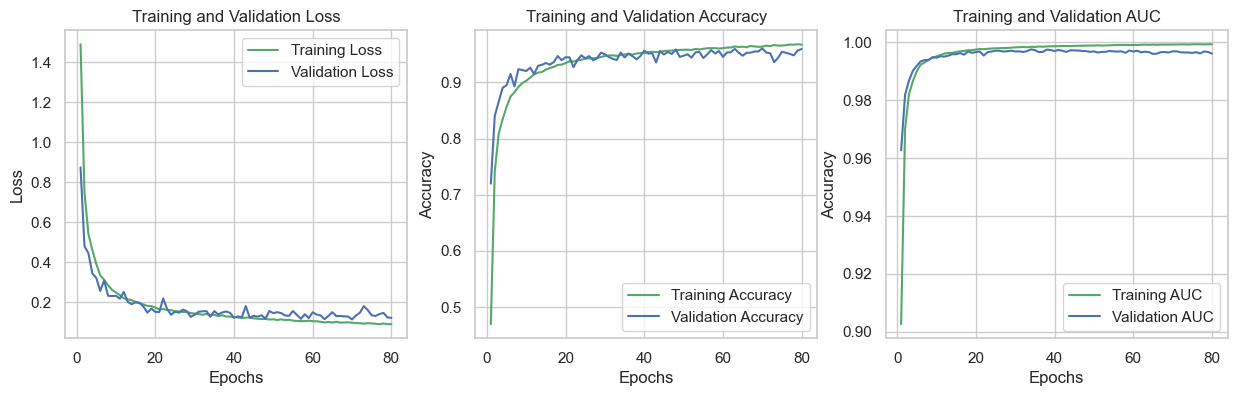

In [ ]:
from tutorial import utils
utils.visulize_training_logs('./results_maps/zscore/training_logs.csv')

### Model Evaluation 

To evaluate the performance of the trained model, the **predict** function is used. This function takes as input a dataset in CSV format, and returns the predicted cell labels along with the probabilities for each class. The output can be further analyzed using various evaluation metrics, such as confusion matrix, precision, recall, F1-score, mean average precision, and precision-recall curve, to determine the performance of the model at the class level. These metrics can help in identifying any potential issues with the model, such as overfitting, and can guide the tuning of hyperparameters for better performance.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from maps.cell_phenotyping import Predictor

pretrained_model_checkpoint_path = './results_maps/zscore/best_checkpoint.pt'
model = Predictor(model_checkpoint_path=pretrained_model_checkpoint_path, num_features=num_features, num_classes=num_classes, batch_size=128)
pred_labels, pred_probs = model.predict(test_data_scaled)

Batch 531/531            

In [28]:
pred_labels, pred_probs = model.predict(test_data_scaled)

Batch 531/531            

In [29]:
# Map the classes to the original cell_type
y_pred = pd.Series(pred_labels).map(cell_label_dict)
y_test = pd.Series(y_test).map(cell_label_dict)

In [30]:
# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
df_f1_scores = pd.DataFrame(report).transpose()

# convert the index to a column
df_f1_scores.reset_index(inplace=True)

df_f1_scores

/Users/arojhada/anaconda3/envs/maps_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arojhada/anaconda3/envs/maps_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arojhada/anaconda3/envs/maps_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

index  precision    recall  f1-score       support
0        B cells   1.000000  0.003717  0.007407    269.000000
1   CD4+ T cells   0.000000  0.000000  0.000000   3204.000000
2   CD8+ T cells   0.000000  0.000000  0.000000   2005.000000
3   Cancer cells   0.000000  0.000000  0.000000  39866.000000
4    Endothelial   0.000000  0.000000  0.000000   5509.000000
5    Fibroblasts   0.000000  0.000000  0.000000   1749.000000
6   Granulocytes   0.000000  0.000000  0.000000    124.000000
7    Macrophages   0.000000  0.000000  0.000000   3861.000000
8     Mast cells   0.000000  0.000000  0.000000     32.000000
9       NK cells   0.000000  0.000000  0.000000    233.000000
10     NKT cells   0.000000  0.000000  0.000000    146.000000
11       T cells   0.000000  0.000000  0.000000   3745.000000
12          Treg   0.000000  0.000000  0.000000    775.000000
13       ungated   0.094806  1.000000  0.173192   6443.000000
14      accuracy   0.094819  0.094819  0.094819      0.094819
15     macro avg   0.078200  0.071694  0.012900  67961.000000
16  weighted avg   0.012946  0.094819  0.016449  67961.000000

In [ ]:
#save the df_f1_scores
df_f1_scores.to_csv('./results_maps/michelson/ROI_03_raw_maps_f1_scores.csv', index=False)

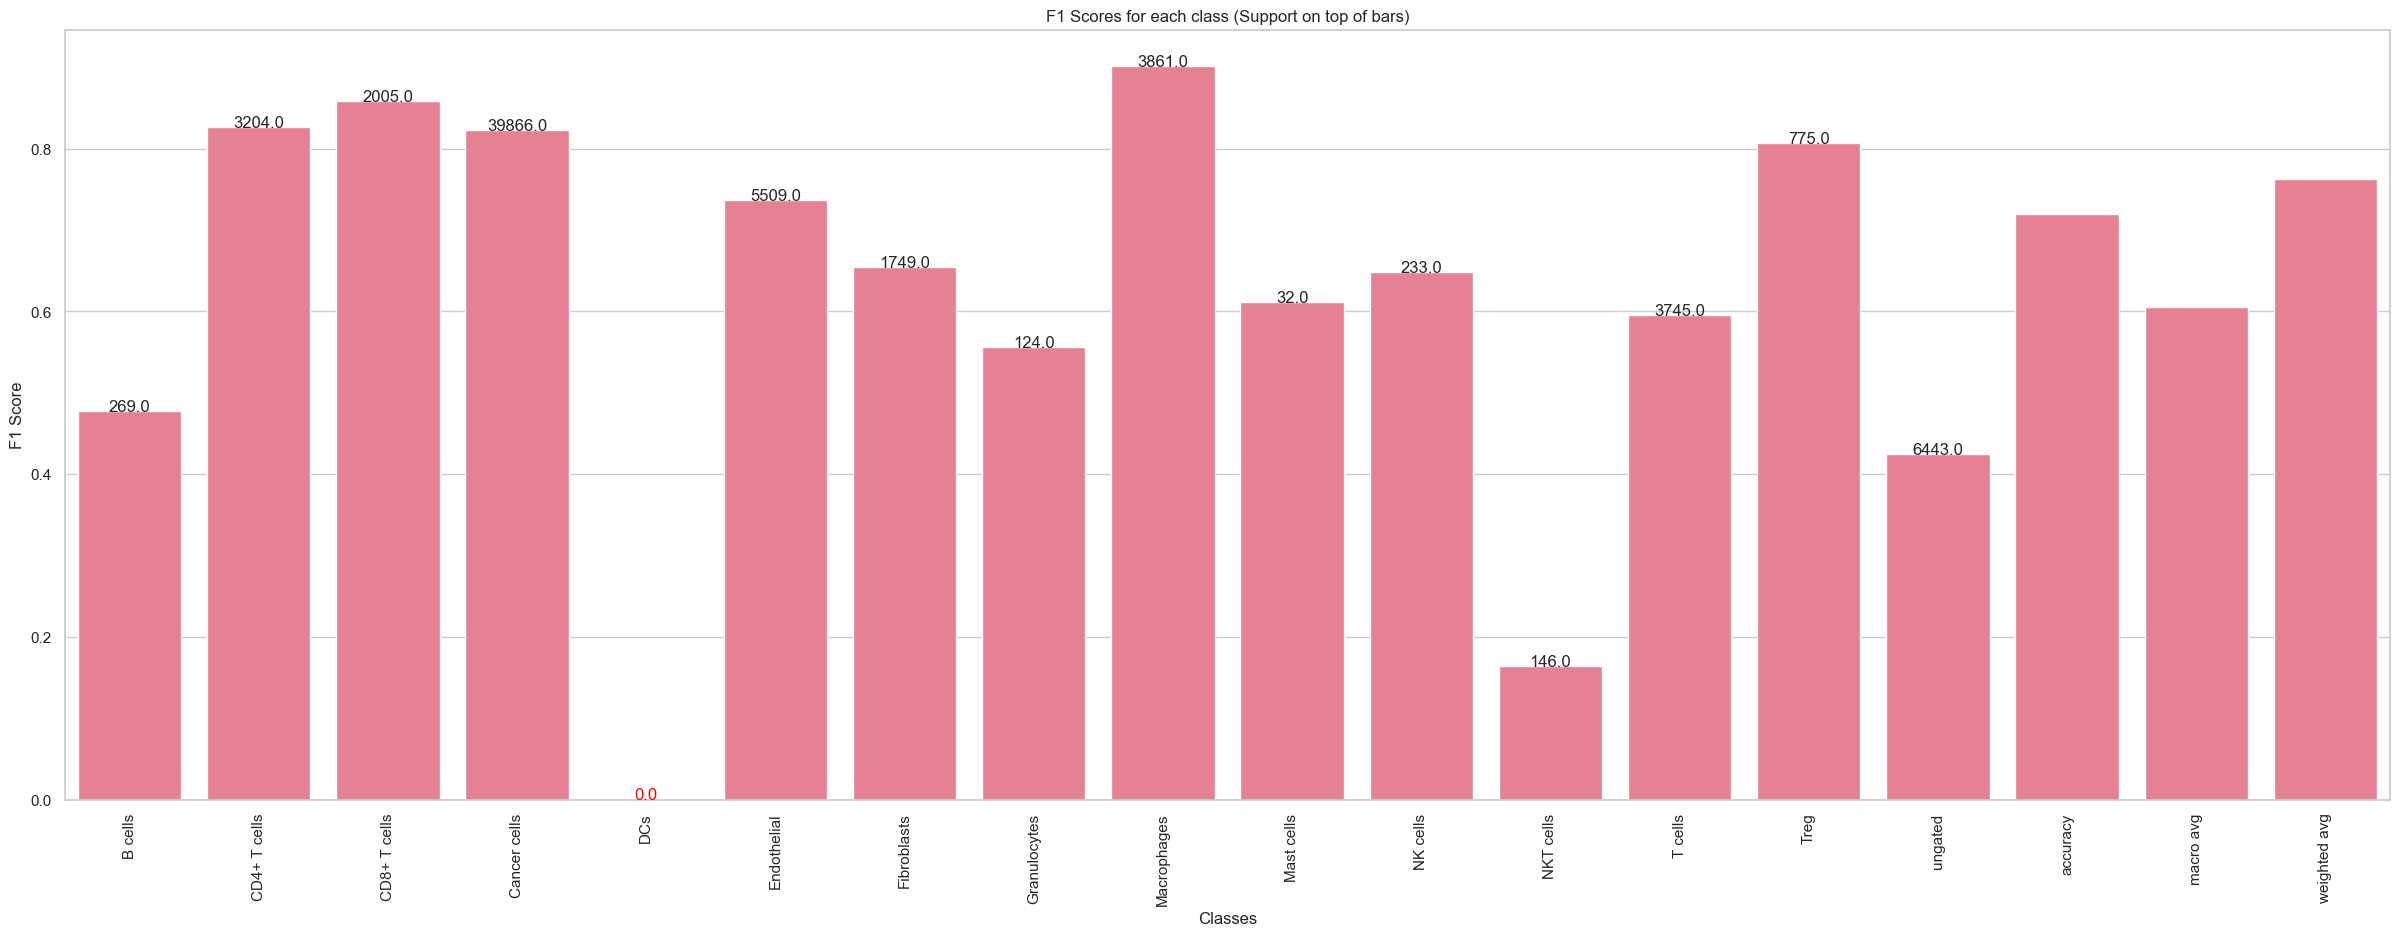

In [18]:
# Plot a bar-plot for tthe F1 scores and the cell types
plt.figure(figsize=(30, 10))
sns.set(style="whitegrid")
sns.set_palette("husl")
sns.barplot(y='f1-score', x='index', data=df_f1_scores)
plt.title('F1 Scores for each class (Support on top of bars)')
plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.xticks(rotation=90)

#plot the support on top of bars except for the last 3 bars and color the text red if the support is less than 10
for i in range(len(df_f1_scores)-3):
    if df_f1_scores['support'][i] < 10:
        plt.text(i, df_f1_scores['f1-score'][i], df_f1_scores['support'][i], ha = 'center', color='red')
    else:
        plt.text(i, df_f1_scores['f1-score'][i], df_f1_scores['support'][i], ha = 'center')

plt.show()

# Save the figure

/var/folders/mg/zdym77mj563f5msk4r9jfc480000gn/T/ipykernel_76408/1991187489.py:5: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


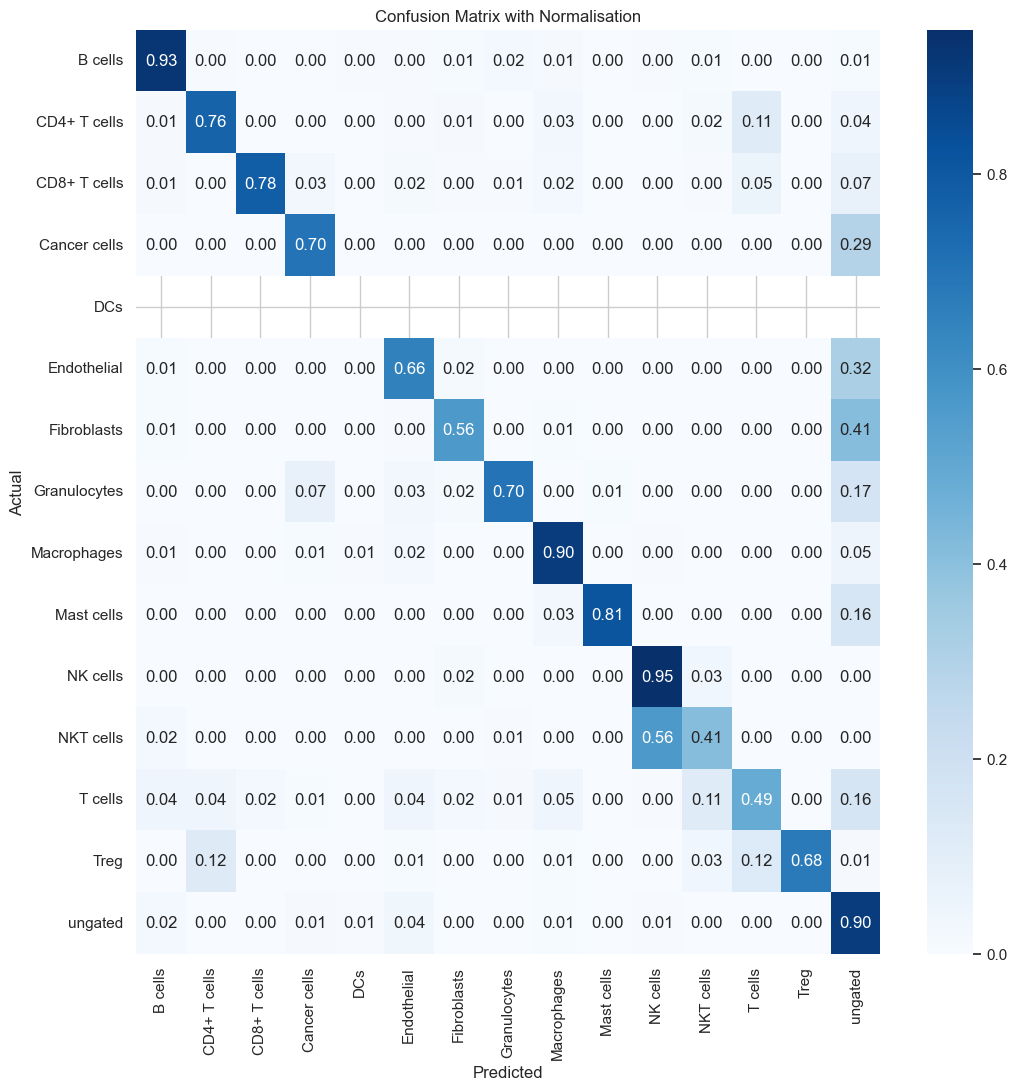

In [19]:
# Calculate the confusion matrix with relative values
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix
# Normalise
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=df_f1_scores['index'][:-3], yticklabels=df_f1_scores['index'][:-3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Normalisation')
plt.show()

#### Model Evaluation Prerequisite

In [9]:
pwd

'/Users/arojhada/SchapiroLab/phenotyping/MAPS'

In [47]:
# Read the csv flie 
import pandas as pd
df = pd.read_csv("../maps_gsk/processed/data_02_deep/data_02_deep.csv")

In [48]:
# save df cell_type as a list
cell_types = df['cell_type'].unique().tolist()
cell_types

['Ki67+ cancer cells',
 'Cancer cells',
 'PCNA+ cancer cells',
 'ungated',
 'CD163+ macrophages',
 'Macrophages',
 'Endothelial',
 'PD1+ CD8+ cells',
 'Mast cells',
 'PCNA+ fibroblasts',
 'Tem CD8+ cells',
 'Fibroblasts',
 'PCNA+ T cells',
 'Teff CD8+ cells',
 'TCF1+ T cells',
 'Ki67+ fibroblasts',
 'Treg',
 'Granulocytes',
 'Tem CD4+ cells',
 'CD39+ Foxp3- CD4+ cells',
 'cleaved PARP1+ cancer cells',
 'NKT cells',
 'Tterm CD8+ cells',
 'DCs',
 'PD1+ Foxp3- CD4+ cells',
 'TIM3+ macrophages',
 'TIM3+ CD8+ cells',
 'CD39+ NK cells',
 'NK cells',
 'T cells',
 'CD39+ T cells',
 'PD1+ T cells',
 'TCF1+ CD8+ cells',
 'PD1+ macrophages',
 'B cells',
 'CD103+ CD8+ cells',
 'Granzyme B+ Foxp3- CD4+ cells',
 'CD39+ CD8+ cells',
 'CD103+ NK cells',
 'PCNA+ Foxp3- CD4+ cells',
 'CD8+ T cells',
 'Tcm CD8+ cells',
 'PCNA+ CD8+ cells',
 'Ki67+ Foxp3- CD4+ cells',
 'Ki67+ T cells',
 'Tcm CD4+ cells',
 'TCF1+ Foxp3- CD4+ cells',
 'TIM3+ T cells',
 'Ki67+ CD8+ cells',
 'TIM3+ Foxp3- CD4+ cells',
 'CD103

In [100]:
import pandas as pd
from tutorial import utils4
#import utils2

# define class names and color palette for visual results 
class_names = cell_types

color_palette =['#bed8d9', '#2bb8b2', '#fed53f', '#f98866', '#fe0000']

# extracting ground truth cell labels for evaluating model performance against ground truth
gt_labels = pd.read_csv(test_data_path)['cell_label'].to_numpy()

#### Confusion Matrix
The confusion matrix provides an overview of the number of correctly and incorrectly classified instances for each class.

In [101]:
utils4.conf_matrix(gt_labels, pred_labels, class_names[:])

/Users/arojhada/anaconda3/envs/maps_env/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


#### Precision, Recall, and F1-score
Precision measures the proportion of true positives among the predicted positives, while recall measures the proportion of true positives among the actual positives. F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.

/Users/arojhada/SchapiroLab/phenotyping/MAPS/tutorial/utils4.py:69: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp/(tp+fp)
/Users/arojhada/SchapiroLab/phenotyping/MAPS/tutorial/utils4.py:70: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp/(tp+fn)
/Users/arojhada/SchapiroLab/phenotyping/MAPS/tutorial/utils4.py:71: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*prec*recall)/(prec+recall)


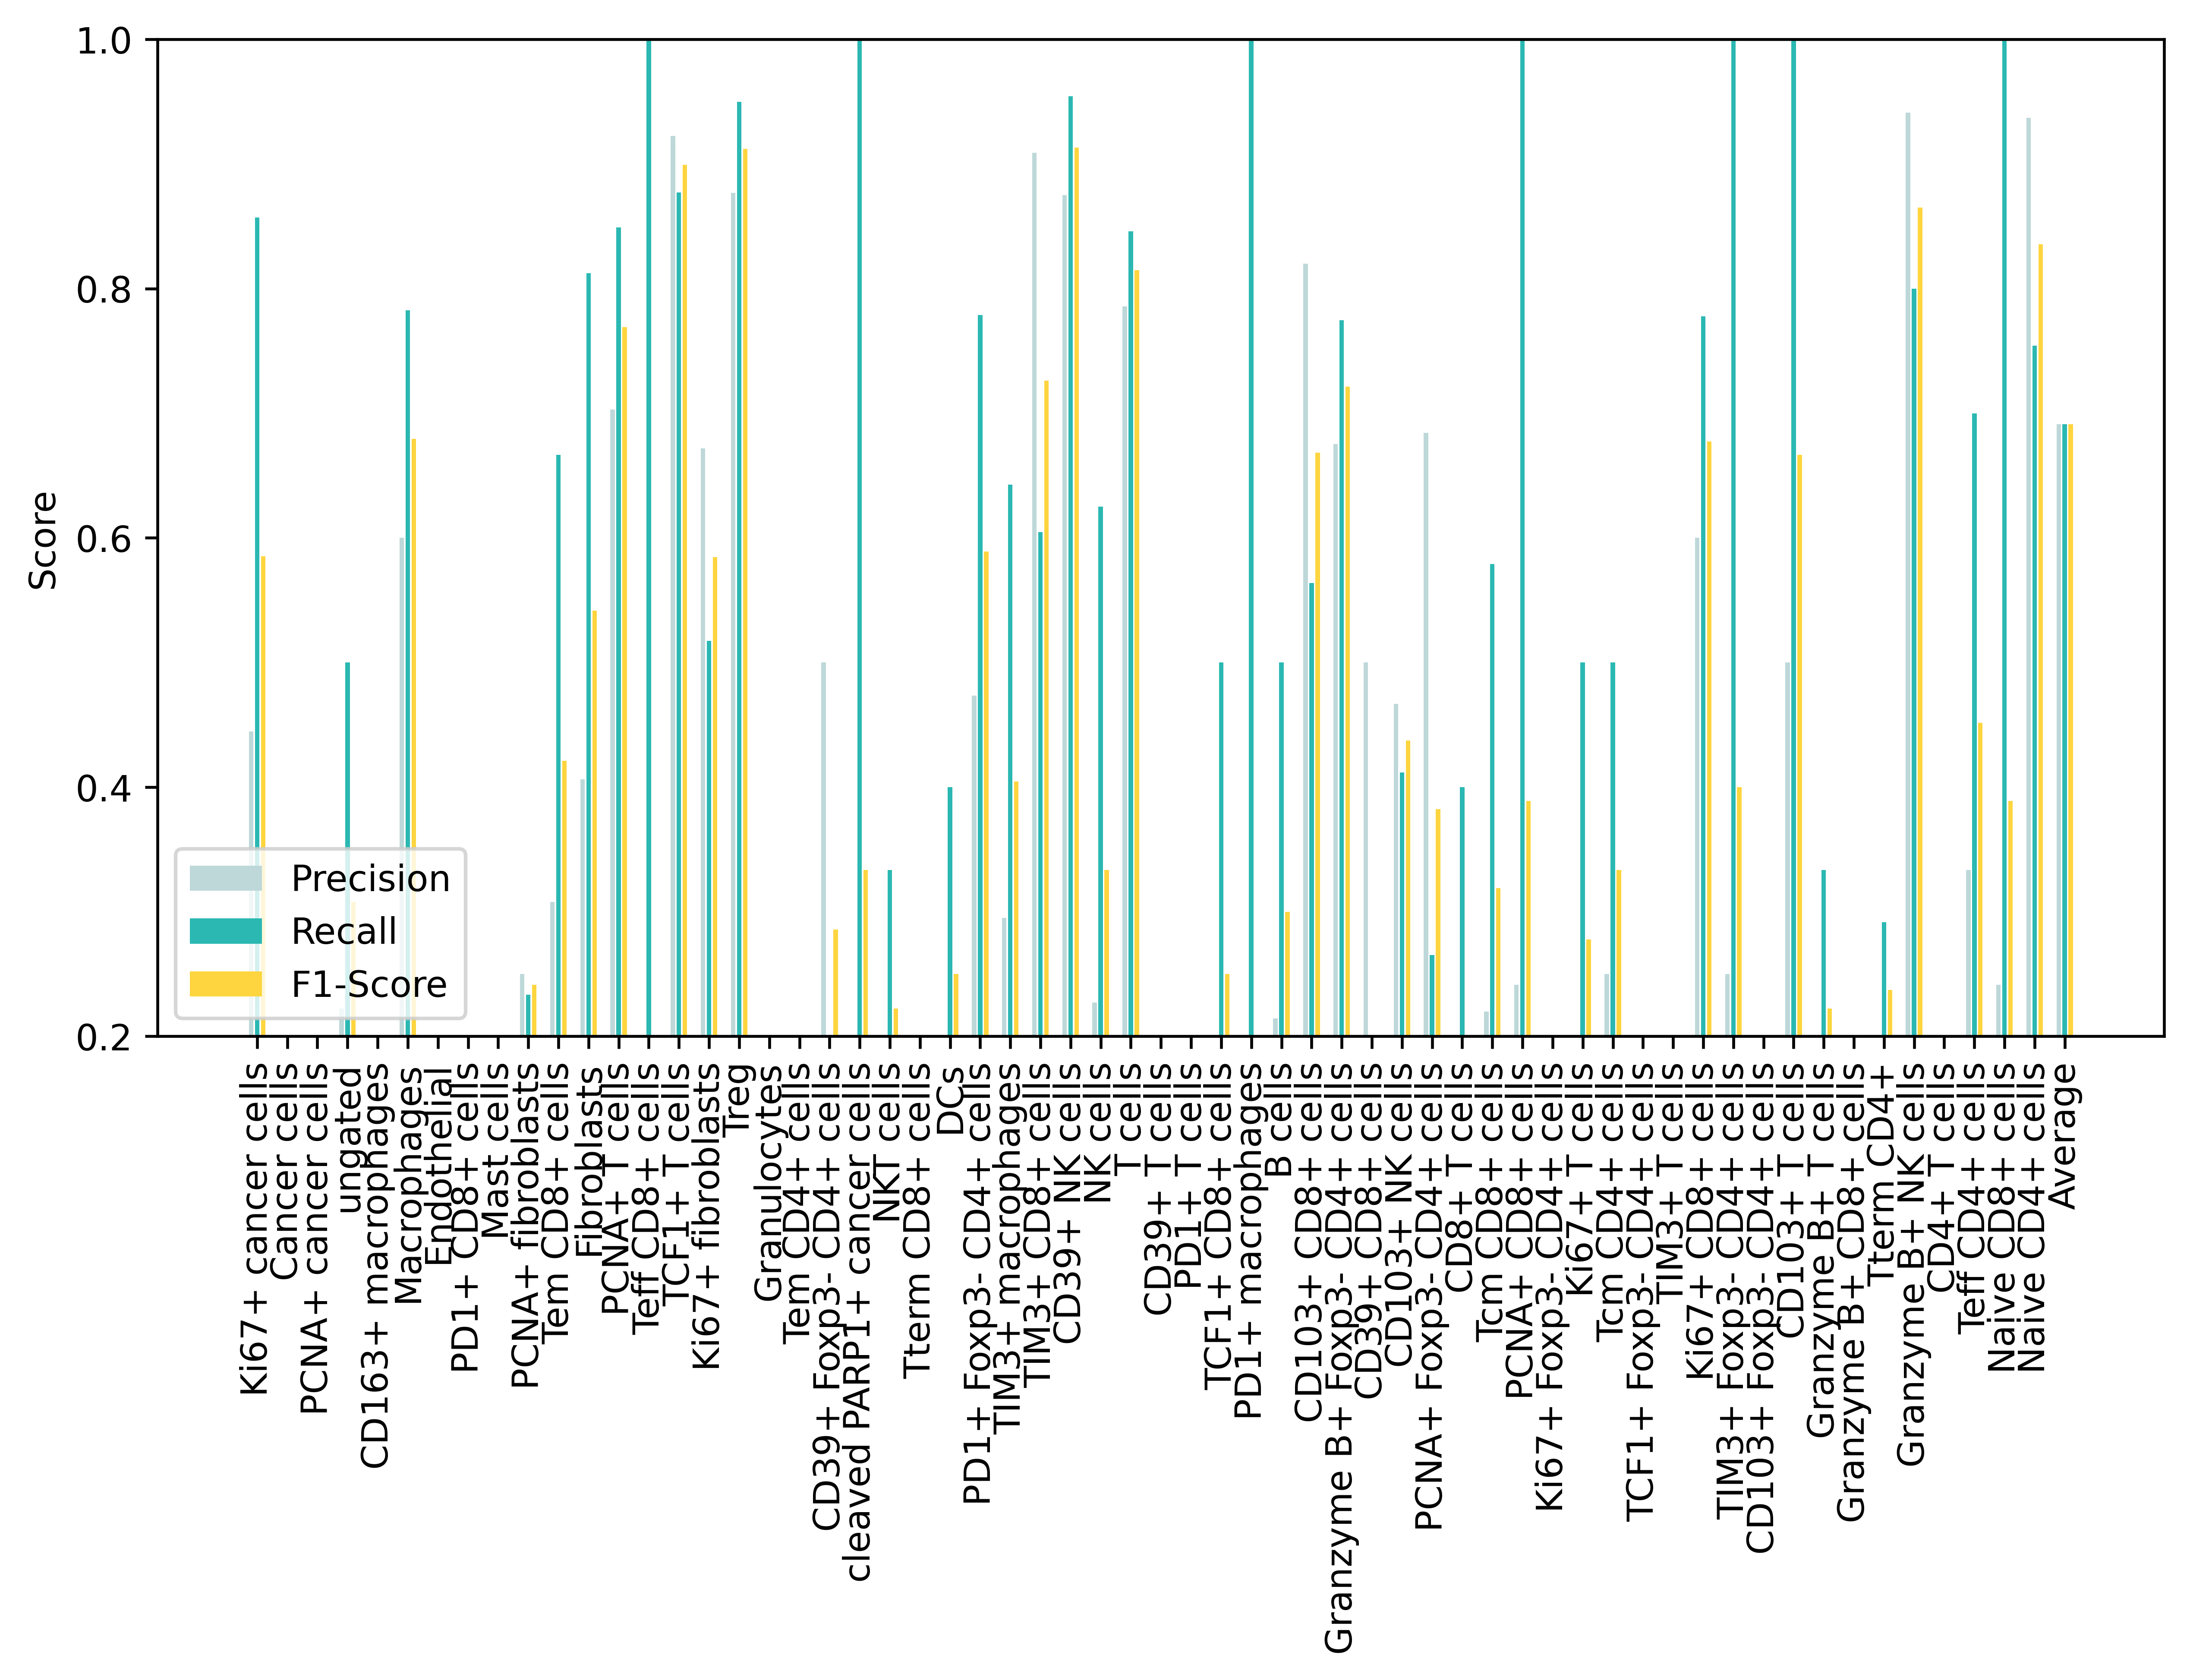

In [102]:
utils4.pre_recall_f1_score(gt_labels, pred_labels, class_names[:], color_palette)

#### Mean average precision (mAP) and Precision Recall Curves
Mean average precision (mAP) computes the average precision across all classes, while the precision-recall curve plots the precision-recall trade-off for different classification thresholds.

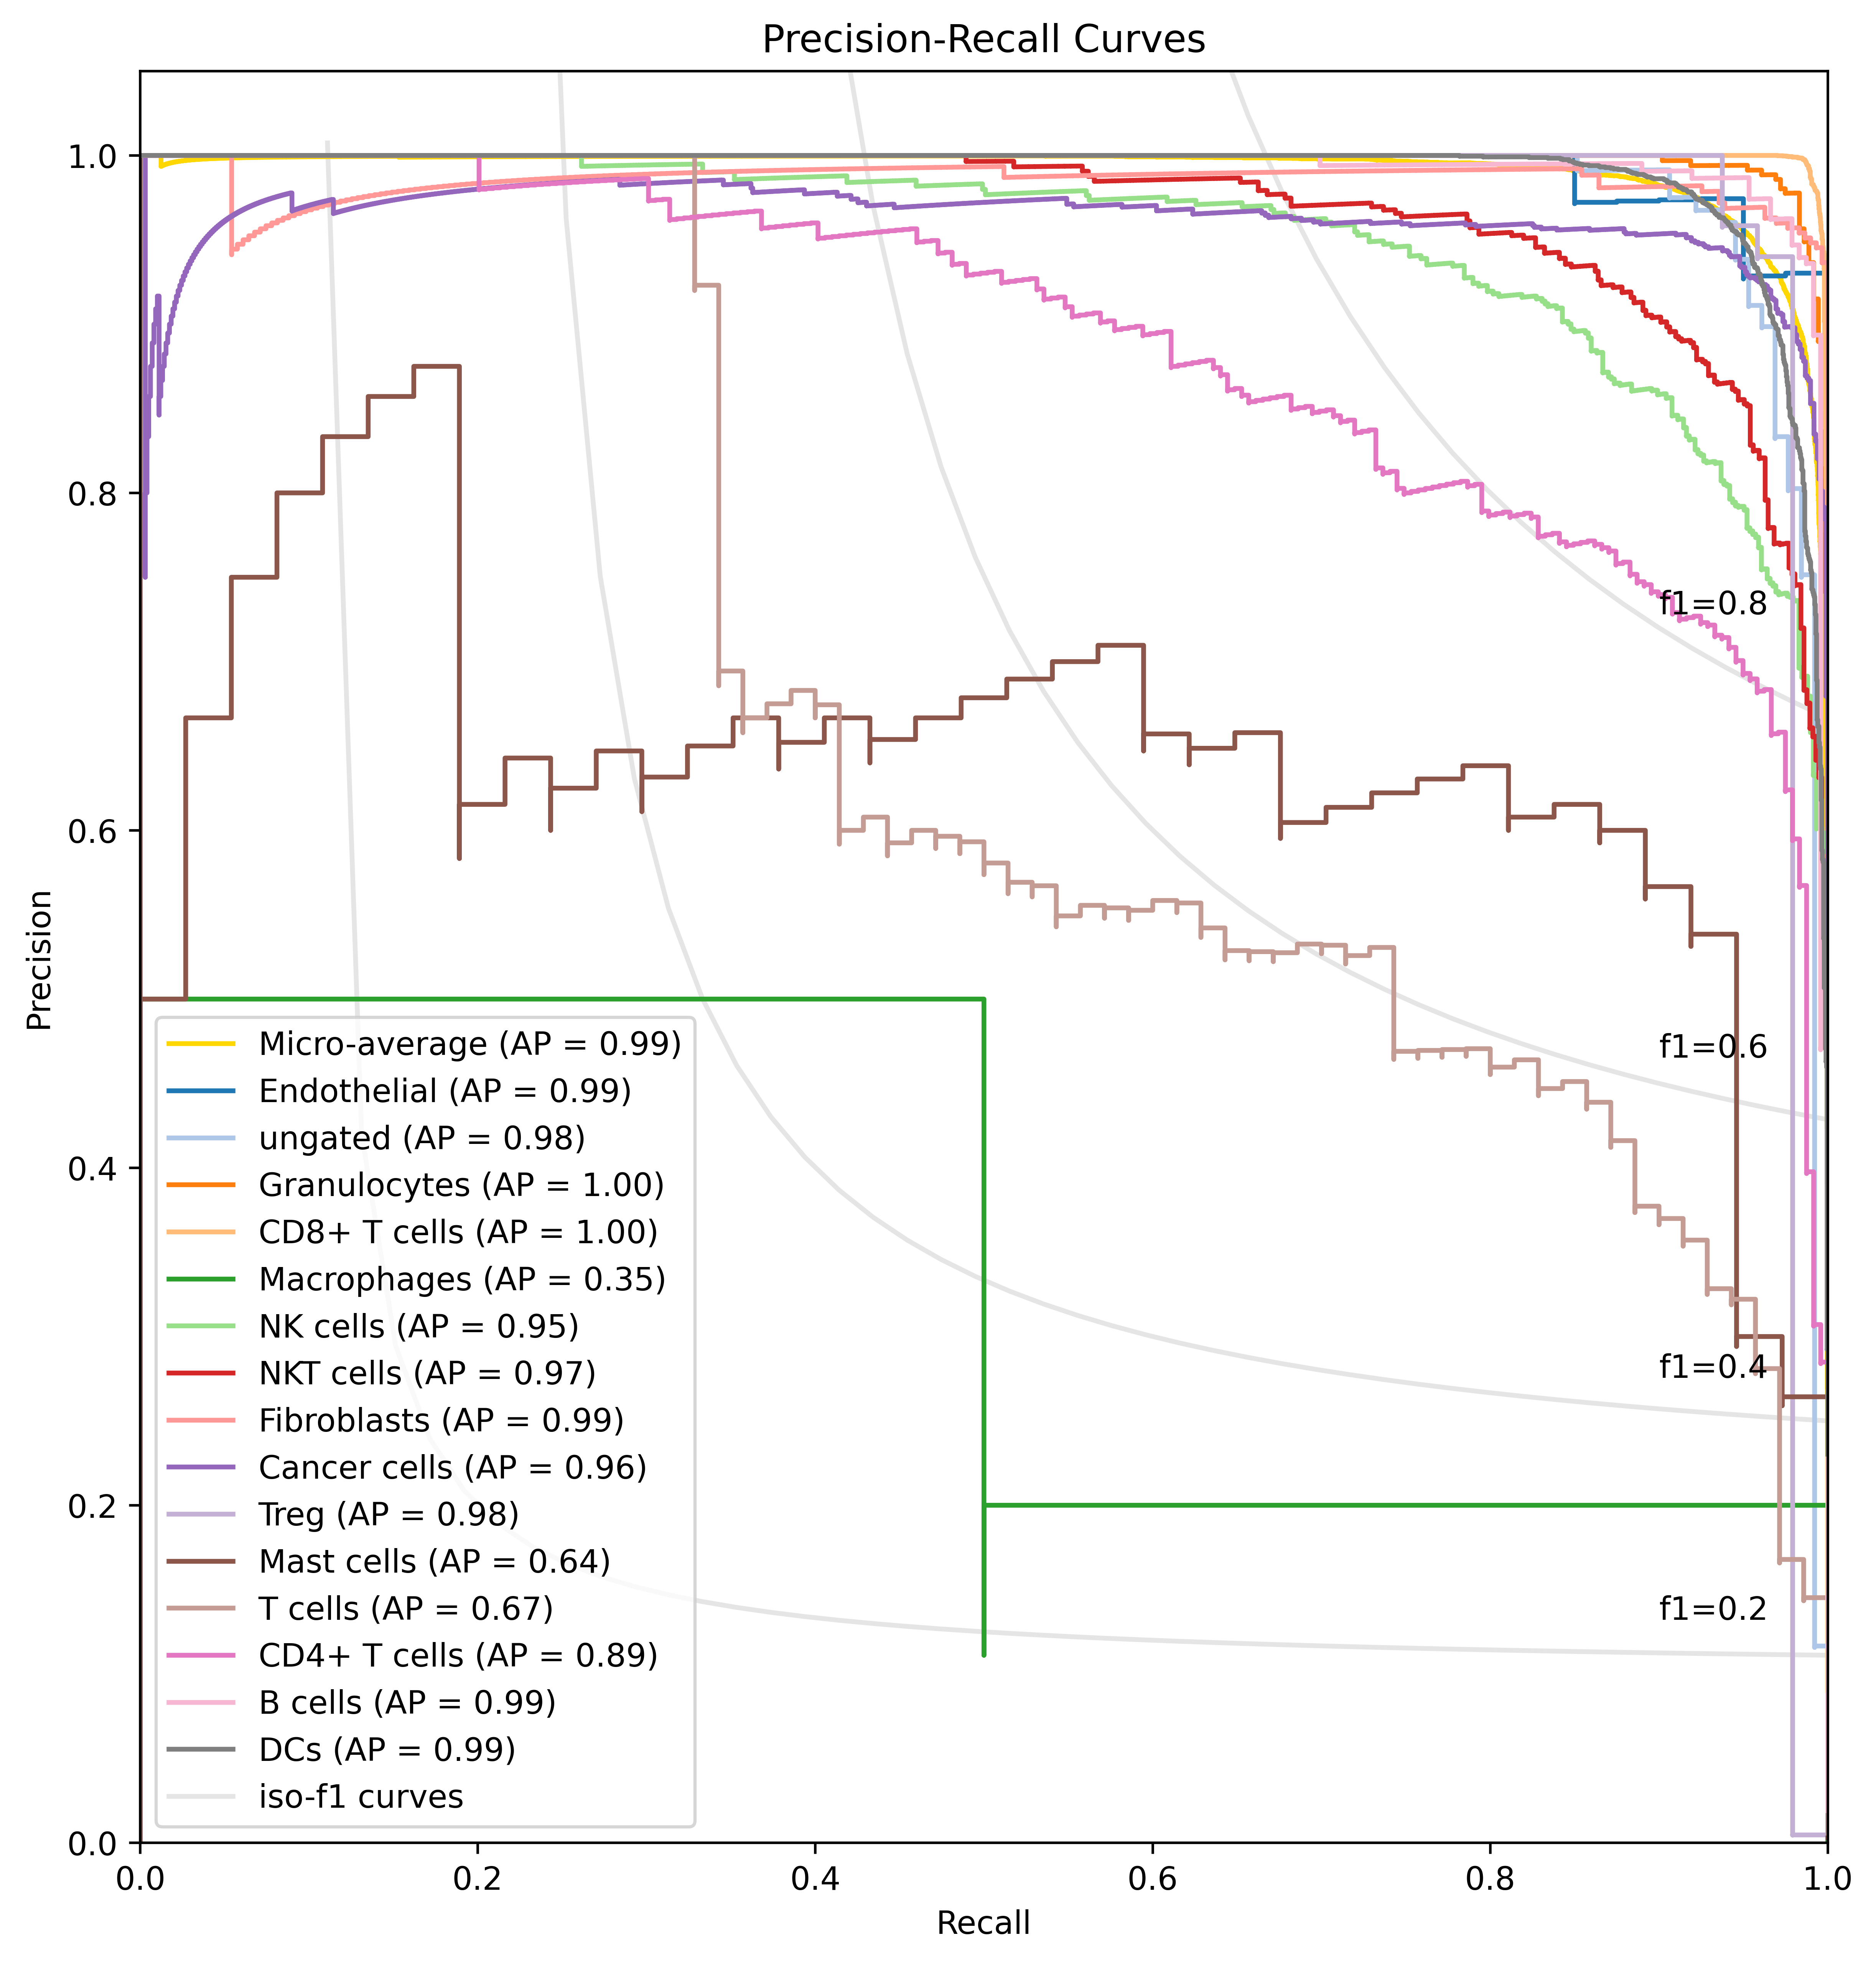

In [42]:
utils.average_pr_curve_per_class(gt_labels, pred_labels, pred_probs, class_names)

# Model Inference I

In [13]:
test03 = pd.read_csv('../raw/data4MAPS/img_data_roi03_expanded_masks.csv')
test04 = pd.read_csv('../raw/data4MAPS/img_data_roi04_expanded_masks.csv')
test05 = pd.read_csv('../raw/data4MAPS/img_data_roi05_expanded_masks.csv')
test06 = pd.read_csv('../raw/data4MAPS/img_data_roi06_expanded_masks.csv')

In [16]:
# Drop the not needed columns
test_data_03 = test03.drop(columns=['Cell', 'X', 'Y'])
test_data_04 = test04.drop(columns=['Cell', 'X', 'Y'])
test_data_05 = test05.drop(columns=['Cell', 'X', 'Y'])
test_data_06 = test06.drop(columns=['Cell', 'X', 'Y'])

In [20]:
# Save the data
test_data_03.to_csv('../maps_gsk/processed/test03.csv', index=False)
test_data_04.to_csv('../maps_gsk/processed/test04.csv', index=False)
test_data_05.to_csv('../maps_gsk/processed/test05.csv', index=False)
test_data_06.to_csv('../maps_gsk/processed/test06.csv', index=False)

# Path to the test data
test_data_03_path = '../maps_gsk/processed/test03.csv'
test_data_04_path = '../maps_gsk/processed/test04.csv'
test_data_05_path = '../maps_gsk/processed/test05.csv'
test_data_06_path = '../maps_gsk/processed/test06.csv'

In [17]:
from maps.cell_phenotyping import Predictor

pretrained_model_checkpoint_path = '../maps_gsk/results/best_checkpoint.pt'
model = Predictor(model_checkpoint_path=pretrained_model_checkpoint_path, num_features=17, num_classes=16, batch_size=128)

In [22]:
pred_labels, pred_probs = model.predict(test_data_03_path)

# Add the predicted labels to the test data 
test03['cell_label'] = pred_labels

# Map cell labels to cell types
test03['cell_type'] = test03['cell_label'].map({1: 'T-cells', 2: 'Granulocytes', 3: 'Cancer', 4: 'Mast Cells', 5: 'Macrophages', 6: 'Fibroblasts', 7: 'B-cell', 8: 'NK', 9: 'plasma', 10: 'Endothelial', 11: 'None', 12: 'CD8 T-cells', 13: 'DP T-cells', 14: 'DN T- cells', 15: 'Tregs', 16: 'Non Treg CD4'})

# Save the results to a csv file
test03.to_csv('../maps_gsk/results/test03_results.csv', index=False)

Batch 342/342            

In [28]:
pred_labels, pred_probs = model.predict(test_data_04_path)

# Add the predicted labels to the test data 
test04['cell_label'] = pred_labels

# Map cell labels to cell types
test04['cell_type'] = test03['cell_label'].map({1: 'T-cells', 2: 'Granulocytes', 3: 'Cancer', 4: 'Mast Cells', 5: 'Macrophages', 6: 'Fibroblasts', 7: 'B-cell', 8: 'NK', 9: 'plasma', 10: 'Endothelial', 11: 'None', 12: 'CD8 T-cells', 13: 'DP T-cells', 14: 'DN T- cells', 15: 'Tregs', 16: 'Non Treg CD4'})

# Save the results to a csv file
test04.to_csv('../maps_gsk/results/test04_results.csv', index=False)

Batch 367/367            

In [29]:
pred_labels, pred_probs = model.predict(test_data_05_path)

# Add the predicted labels to the test data 
test05['cell_label'] = pred_labels

# Map cell labels to cell types
test05['cell_type'] = test03['cell_label'].map({1: 'T-cells', 2: 'Granulocytes', 3: 'Cancer', 4: 'Mast Cells', 5: 'Macrophages', 6: 'Fibroblasts', 7: 'B-cell', 8: 'NK', 9: 'plasma', 10: 'Endothelial', 11: 'None', 12: 'CD8 T-cells', 13: 'DP T-cells', 14: 'DN T- cells', 15: 'Tregs', 16: 'Non Treg CD4'})

# Save the results to a csv file
test05.to_csv('../maps_gsk/results/test05_results.csv', index=False)

Batch 489/489            

In [30]:
pred_labels, pred_probs = model.predict(test_data_06_path)

# Add the predicted labels to the test data 
test06['cell_label'] = pred_labels

# Map cell labels to cell types
test06['cell_type'] = test03['cell_label'].map({1: 'T-cells', 2: 'Granulocytes', 3: 'Cancer', 4: 'Mast Cells', 5: 'Macrophages', 6: 'Fibroblasts', 7: 'B-cell', 8: 'NK', 9: 'plasma', 10: 'Endothelial', 11: 'None', 12: 'CD8 T-cells', 13: 'DP T-cells', 14: 'DN T- cells', 15: 'Tregs', 16: 'Non Treg CD4'})

# Save the results to a csv file
test06.to_csv('../maps_gsk/results/test06_results.csv', index=False)

Batch 569/569            